In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary

In [2]:
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
train_df = pd.read_csv("/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv")
train_df

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


In [4]:
train_df["target_feature"].value_counts(normalize=True) 
# Видим, что в исходных данных всего 16 типов данных, а не 20, как в справочнике - потом надо переделать модель на 16 классов
# Потом можно добавить график

target_feature
0     0.203121
3     0.135845
9     0.098892
5     0.079405
6     0.064688
16    0.060888
4     0.060807
8     0.043099
2     0.042856
11    0.042694
12    0.037924
13    0.035740
18    0.033153
10    0.031536
14    0.018436
1     0.010916
Name: proportion, dtype: float64

In [5]:
# Если делать модель на 20 классах, 
# то на одних и тех же данных то метрика на валидации будет отличаться от метрики на нашей валидации.
# Например у нас f1 0.39, а на лидерборде около 0.5. Если классов сделать 16 (как на самом деле есть), 
# то на этих же предсказаниях метрика будет уже 0.49 (f1 чуствительна к количеству классов)
# Самое просто это перекодировать классы. Например (просто берем по уменьшении доли класс)

target_feature_to_class_id = {
    0:0,
    3:1,
    9:2,
    5:3,
    6:4,
    16:5,
    4:6,
    8:7,
    2:8,
    11:9,
    12:10,
    13:11,
    18:12,
    10:13,
    14:14,
    1:15,
}

class_id_to_target_feature = {v:k for k,v in target_feature_to_class_id.items()}

print(f'target_feature -> class_id', target_feature_to_class_id)
print(f'class_id -> target_feature', class_id_to_target_feature)

target_feature -> class_id {0: 0, 3: 1, 9: 2, 5: 3, 6: 4, 16: 5, 4: 6, 8: 7, 2: 8, 11: 9, 12: 10, 13: 11, 18: 12, 10: 13, 14: 14, 1: 15}
class_id -> target_feature {0: 0, 1: 3, 2: 9, 3: 5, 4: 6, 5: 16, 6: 4, 7: 8, 8: 2, 9: 11, 10: 12, 11: 13, 12: 18, 13: 10, 14: 14, 15: 1}


In [6]:
# Заменим 20 классов на новые идентификатры 16 классов
train_df['target_feature'] = train_df['target_feature'].replace(target_feature_to_class_id)
train_df

,img_id,target_feature
0,17363,8
1,8612,3
2,8244,0
3,9264,0
4,5382,4
...,...,...
12362,11503,6
12363,12201,4
12364,5489,1
12365,883,3


In [7]:
# Разделим данные на train и valid сохранением доли таргета
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=5, shuffle=True, stratify=train_df["target_feature"])

In [8]:
# Проверим, что доли таргета не поменялись. Потом можно добавить график
print(train_df["target_feature"].value_counts(normalize=True))
print(valid_df["target_feature"].value_counts(normalize=True))

target_feature
0     0.203174
1     0.135854
2     0.098858
3     0.079450
4     0.064692
5     0.060851
6     0.060851
7     0.043061
8     0.042859
9     0.042656
10    0.037906
11    0.035783
12    0.033155
13    0.031537
14    0.018397
15    0.010917
Name: proportion, dtype: float64
target_feature
0     0.202910
1     0.135812
2     0.099030
3     0.079224
4     0.064673
5     0.061035
6     0.060631
7     0.043250
8     0.042846
9     0.042846
10    0.037995
11    0.035570
12    0.033145
13    0.031528
14    0.018593
15    0.010914
Name: proportion, dtype: float64


In [9]:
# Класс для загрузки картинок и информации о них
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [10]:
from torchvision.transforms import v2
# https://pytorch.org/vision/stable/transforms.html

transform_train = v2.Compose([
    v2.Resize(256),    
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_train
)

valid_dataset = ImageDataset(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_valid
)

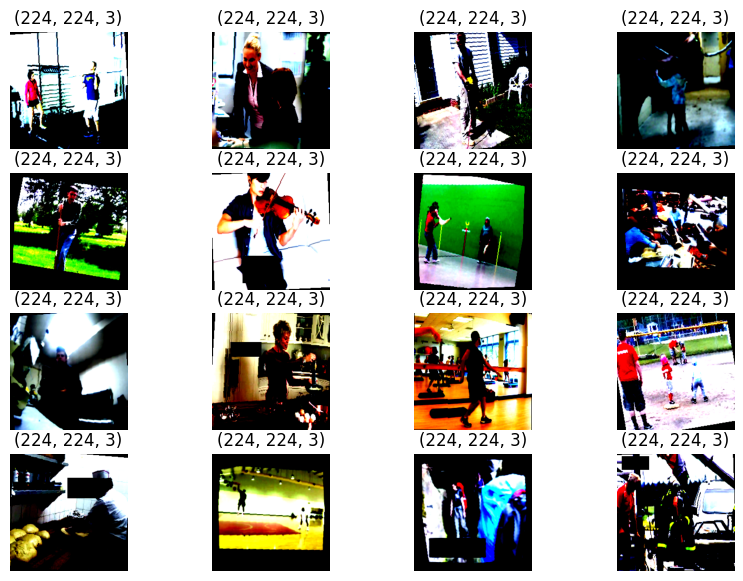

In [11]:
plt.figure(figsize=(10, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{img.shape}")

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
# !rm -r /kaggle/working/models

# Вспомогательные функции (предсказание/графики)

In [14]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Average, RunningAverage, Precision, Recall, Fbeta
from ignite.utils import convert_tensor

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [15]:
def predict_model_pred(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )
    
    pred_list = []
    
    def compute_epoch_results(engine):
        pred_list.append(engine.state.output.cpu().numpy())
        
    test_engine.add_event_handler(Events.ITERATION_COMPLETED, compute_epoch_results)
    
    # Создаем прогресс-бар
    progress_bar = ProgressBar()
    
    # Привязываем к trainer
    progress_bar.attach(test_engine)
    
    # Запускаем предсказание
    test_engine_output = test_engine.run(dataloader)

    # Объединяем предсказания в разных batch
    pred = np.concatenate(pred_list)
    print(pred.shape)

    return pred
    
def predict_model(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )
    
    pred = predict_model_pred(model, dataloader, device)

    # Максимум это предсказанный класс
    pred = pred.argmax(1)
    print(pred.shape)

    return pred

# Предсказание

In [16]:
# Соберем pandas DataFrame для тестовых данных и из него сделаем тестовый датасет
file_list = os.listdir('/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test')
img_id_list = [int(file_name.split(".")[0]) for file_name in file_list]

In [17]:
test_df = pd.DataFrame({
    "img_id": img_id_list,
    "target_feature": -1
})
test_df

,img_id,target_feature
0,16916,-1
1,12666,-1
2,623,-1
3,11925,-1
4,2008,-1
...,...,...
5296,728,-1
5297,1656,-1
5298,3361,-1
5299,2599,-1


In [18]:
batch_size = 256
test_dataset = ImageDataset(
    df=test_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test",
    transform=transform_valid
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [19]:
test_pred_list = []

## Предскажем первой моделью
Public score: 0.62863
https://www.kaggle.com/code/kirachistiakova/baseline?scriptVersionId=233714776

In [20]:
def create_conv_model(dropout_conv = 0.1, dropout_linear = 0.3):
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(dropout_conv),
        
        # nn.Flatten(),
        # nn.Linear(in_features=25088, out_features=256),
        # nn.BatchNorm1d(256),
        # nn.ReLU(),
        # nn.Dropout(dropout_linear),
        # nn.Linear(in_features=256, out_features=16),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=16),
    
    )
    print(summary(model, input_size=(256, 3, 224, 224), col_names=["input_size", "output_size", "num_params"], depth=3))
    return model

In [21]:
# Предскажем моделью с оптимальной эпохи
model = create_conv_model()

model_path = '/kaggle/input/convnet_model_0.6471.pt/pytorch/default/1/convnet_model_0.6471.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

test_pred = predict_model_pred(model, test_dataloader, device)
test_pred_list.append(test_pred)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [256, 3, 224, 224]        [256, 16]                 --
├─Conv2d: 1-1                            [256, 3, 224, 224]        [256, 32, 224, 224]       896
├─BatchNorm2d: 1-2                       [256, 32, 224, 224]       [256, 32, 224, 224]       64
├─ReLU: 1-3                              [256, 32, 224, 224]       [256, 32, 224, 224]       --
├─MaxPool2d: 1-4                         [256, 32, 224, 224]       [256, 32, 112, 112]       --
├─Dropout2d: 1-5                         [256, 32, 112, 112]       [256, 32, 112, 112]       --
├─Conv2d: 1-6                            [256, 32, 112, 112]       [256, 64, 112, 112]       18,496
├─BatchNorm2d: 1-7                       [256, 64, 112, 112]       [256, 64, 112, 112]       128
├─ReLU: 1-8                              [256, 64, 112, 112]       [256, 64, 112, 112]       --
├─MaxPool2d: 1-9             

/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[1/21]   5%|4          [00:00<?]

(5301, 16)


## Предскажем второй моделью
Public score: 0.62340
https://www.kaggle.com/code/kirachistiakova/baseline?scriptVersionId=234130421

In [22]:
# Сделаем модель с skip-conection
def create_resnet18_model(dropout_conv = 0.1, dropout_linear = 0.5, max_drop_path_rate=0.2):

    class DropPath(nn.Module):
        def __init__(self, drop_prob=0.0):
            super().__init__()
            self.drop_prob = drop_prob

        def forward(self, x):
            if self.drop_prob == 0. or not self.training:
                return x
            keep_prob = 1 - self.drop_prob
            shape = (x.shape[0],) + (1,) * (x.ndim - 1)
            random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
            random_tensor.floor_()
            return x.div(keep_prob) * random_tensor

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride, drop_path_prob=0.1):
            super().__init__()

            self.main = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.Dropout2d(dropout_conv),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout2d(dropout_conv),
            )

            self.skip = nn.Identity() if in_channels == out_channels and stride == 1 else nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )

            self.drop_path = DropPath(drop_prob=drop_path_prob)
            self.final_relu = nn.LeakyReLU(0.1)

        def forward(self, x):
            return self.final_relu(self.drop_path(self.main(x)) + self.skip(x))


    drop_path_rate = [x.item() for x in torch.linspace(0, max_drop_path_rate, 8)]  # 8 blocks total
    channels = 64

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[0]),
        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[1]),

        ResidualBlock(in_channels=channels, out_channels=channels*2, stride=2, drop_path_prob=drop_path_rate[2]),
        ResidualBlock(in_channels=channels*2, out_channels=channels*2, stride=1, drop_path_prob=drop_path_rate[3]),

        ResidualBlock(in_channels=channels*2, out_channels=channels*4, stride=2, drop_path_prob=drop_path_rate[4]),
        ResidualBlock(in_channels=channels*4, out_channels=channels*4, stride=1, drop_path_prob=drop_path_rate[5]),

        ResidualBlock(in_channels=channels*4, out_channels=channels*8, stride=2, drop_path_prob=drop_path_rate[6]),
        ResidualBlock(in_channels=channels*8, out_channels=channels*8, stride=1, drop_path_prob=drop_path_rate[7]),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_linear),
        nn.Linear(in_features=channels*8, out_features=16),
    )

    print(summary(model, input_size=(256, 3, 224, 224), col_names=["input_size", "output_size", "num_params"], depth=3))
    return model

In [23]:
# Предскажем моделью с оптимальной эпохи
model = create_resnet18_model()

model_path = '/kaggle/input/resnet18_model_0.7129.pt/pytorch/default/1/resnet18_model_0.7129.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

test_pred = predict_model_pred(model, test_dataloader, device)
test_pred_list.append(test_pred)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [256, 3, 224, 224]        [256, 16]                 --
├─Conv2d: 1-1                            [256, 3, 224, 224]        [256, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [256, 64, 112, 112]       [256, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [256, 64, 112, 112]       [256, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [256, 64, 112, 112]       [256, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    └─Sequential: 2-1                   [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─BatchNorm2d: 3-1             [256, 64, 56, 56]         [256, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-2               [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-3       

[1/21]   5%|4          [00:00<?]

(5301, 16)


In [24]:
# Среднее из первых двух дает 0.65646 - именно ее будем смешивать с новой моделью в 0.65676
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

test_pred_list = []
test_pred_list.append(test_pred)

(2, 5301, 16)
(5301, 16)


## Предскажем третьей моделью
Public score: 0.65676
https://www.kaggle.com/code/kirachistiakova/resnet18?scriptVersionId=234774589

In [25]:
# Сделаем модель с skip-conection
def create_resnet18_model(dropout_conv = 0.1, dropout_linear = 0.5, max_drop_path_rate=0.2):

    class DropPath(nn.Module):
        def __init__(self, drop_prob=0.0):
            super().__init__()
            self.drop_prob = drop_prob

        def forward(self, x):
            if self.drop_prob == 0. or not self.training:
                return x
            keep_prob = 1 - self.drop_prob
            shape = (x.shape[0],) + (1,) * (x.ndim - 1)
            random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
            random_tensor.floor_()
            return x.div(keep_prob) * random_tensor

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride, drop_path_prob=0.1):
            super().__init__()

            self.main = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                # nn.Dropout2d(dropout_conv),

                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                nn.Dropout2d(dropout_conv),
            )

            self.skip = nn.Identity() if in_channels == out_channels and stride == 1 else nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )

            self.drop_path = DropPath(drop_prob=drop_path_prob)
            self.final_relu = nn.LeakyReLU(0.1)

        def forward(self, x):
            x = self.drop_path(self.main(x)) + self.skip(x)
            x = self.final_relu(x)
            return x


    drop_path_rate = [x.item() for x in torch.linspace(0, max_drop_path_rate, 8)]  # 8 blocks total
    channels = 64

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[0]),
        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[1]),

        ResidualBlock(in_channels=channels, out_channels=channels*2, stride=2, drop_path_prob=drop_path_rate[2]),
        ResidualBlock(in_channels=channels*2, out_channels=channels*2, stride=1, drop_path_prob=drop_path_rate[3]),

        ResidualBlock(in_channels=channels*2, out_channels=channels*4, stride=2, drop_path_prob=drop_path_rate[4]),
        ResidualBlock(in_channels=channels*4, out_channels=channels*4, stride=1, drop_path_prob=drop_path_rate[5]),

        ResidualBlock(in_channels=channels*4, out_channels=channels*8, stride=2, drop_path_prob=drop_path_rate[6]),
        ResidualBlock(in_channels=channels*8, out_channels=channels*8, stride=1, drop_path_prob=drop_path_rate[7]),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_linear),
        nn.Linear(in_features=channels*8, out_features=16),
    )

    print(summary(model, input_size=(128, 3, 224, 224), col_names=["input_size", "output_size", "num_params"], depth=3))
    return model

create_resnet18_model()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 224, 224]        [128, 16]                 --
├─Conv2d: 1-1                            [128, 3, 224, 224]        [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       [128, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [128, 64, 112, 112]       [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 112, 112]       [128, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    └─Sequential: 2-1                   [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         [128, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-3

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Dropout2d(p=0.1, inplace=False)
    )
    (skip): Identity()
    (drop_path): DropPath()
    (final_relu): LeakyReLU(negative_slope=0.1)
  )
  (5): ResidualBlock(
    (main): Sequential(
      (0): C

In [26]:
# Предскажем моделью с оптимальной эпохи
model = create_resnet18_model()

model_path = '/kaggle/input/resnet18/models/resnet18_full_model_2_valid_f1=0.7341.pt'
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

test_pred = predict_model_pred(model, test_dataloader, device)
test_pred_list.append(test_pred)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 224, 224]        [128, 16]                 --
├─Conv2d: 1-1                            [128, 3, 224, 224]        [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       [128, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [128, 64, 112, 112]       [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 112, 112]       [128, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    └─Sequential: 2-1                   [128, 64, 56, 56]         [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         [128, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-3

[1/21]   5%|4          [00:00<?]

(5301, 16)


## Объединим предсказания (возьмем среднее)

In [27]:
# Объединим предсказания нескольких моделей
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# При смешивании выходов из разных моделей надо не забывать сначала применять softmax по последнему измерению
# from scipy.special import softmax
# test_pred = softmax(test_pred, axis=2)  # axis=2 - последнее измерение

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
print(test_pred.shape)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred
    
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)
    
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_mean.csv', index=False)

(2, 5301, 16)
(5301, 16)
(5301,)
